In [1]:
import numpy as np
import pdb
# from mmaction.core import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
%matplotlib inline
# plt.switch_backend('agg')

In [2]:
def confusion_matrix(y_pred, y_real, normalize=None):
    """Compute confusion matrix.

    Args:
        y_pred (list[int] | np.ndarray[int]): Prediction labels.
        y_real (list[int] | np.ndarray[int]): Ground truth labels.
        normalize (str | None): Normalizes confusion matrix over the true
            (rows), predicted (columns) conditions or all the population.
            If None, confusion matrix will not be normalized. Options are
            "true", "pred", "all", None. Default: None.

    Returns:
        np.ndarray: Confusion matrix.
    """
    if normalize not in ['true', 'pred', 'all', None]:
        raise ValueError("normalize must be one of {'true', 'pred', "
                         "'all', None}")

    if isinstance(y_pred, list):
        y_pred = np.array(y_pred)
    if not isinstance(y_pred, np.ndarray):
        raise TypeError(
            f'y_pred must be list or np.ndarray, but got {type(y_pred)}')
    if not y_pred.dtype == np.int64:
        raise TypeError(
            f'y_pred dtype must be np.int64, but got {y_pred.dtype}')

    if isinstance(y_real, list):
        y_real = np.array(y_real)
    if not isinstance(y_real, np.ndarray):
        raise TypeError(
            f'y_real must be list or np.ndarray, but got {type(y_real)}')
    if not y_real.dtype == np.int64:
        raise TypeError(
            f'y_real dtype must be np.int64, but got {y_real.dtype}')

    label_set = np.unique(np.concatenate((y_pred, y_real)))
    num_labels = len(label_set)
    label_map = {label: i for i, label in enumerate(label_set)}
    confusion_mat = np.zeros((num_labels, num_labels), dtype=np.int64)
    for rlabel, plabel in zip(y_real, y_pred):
        index_real = label_map[rlabel]
        index_pred = label_map[plabel]
        confusion_mat[index_real][index_pred] += 1

    with np.errstate(all='ignore'):
        if normalize == 'true':
            confusion_mat = (
                confusion_mat / confusion_mat.sum(axis=1, keepdims=True))
        elif normalize == 'pred':
            confusion_mat = (
                confusion_mat / confusion_mat.sum(axis=0, keepdims=True))
        elif normalize == 'all':
            confusion_mat = (confusion_mat / confusion_mat.sum())
        confusion_mat = np.nan_to_num(confusion_mat)

    return confusion_mat

In [14]:
# set up path for thh reference (baseline) model prediction and its ground truth
# The reason why we have two different ground truth is that the orders could be different across different machines
# ref_prediction_path = '../../work_dirs/r2plus1d_r34_video_3d_8x8x1_900e_ucf101_rgb_20percent_vidssl/results.pkl'
# ref_gt_labels_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_180e_ucf101_rgb_fixmatch_20percent_vidssl/gt_labels.npy'

ref_prediction_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_360e_ucf101_rgb_all_20percent_vidssl/results.pkl' # final model, CVPR
ref_gt_labels_path = '../../work_dirs/r2plus1d_r34_video_3d_8x8x1_900e_ucf101_rgb_20percent_vidssl/gt_labels_new.npy'

# class names 
classnames_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_180e_ucf101_rgb_fixmatch_20percent_vidssl/classnames.npy'

# set up the path for the compared (proposed) model predictions, and its ground truth
# comp_prediction_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_360e_ucf101_rgb_all_20percent_vidssl/results.pkl' # final model
# comp_gt_labels_path = '../../work_dirs/r2plus1d_r34_video_3d_8x8x1_900e_ucf101_rgb_20percent_vidssl/gt_labels_new.npy'

comp_prediction_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_45e_ucf101-kinetics100_rgb_all_full_vidssl_1GPU/results.pkl' # final model
comp_gt_labels_path = '../../work_dirs/r2plus1d_r34_video_3d_8x8x1_900e_ucf101_rgb_20percent_vidssl/gt_labels_new.npy'

# comp_prediction_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_180e_ucf101_rgb_taugment_20percent_vidssl/results.pkl' # temp aug all only
# comp_gt_labels_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_180e_ucf101_rgb_fixmatch_20percent_vidssl/gt_labels.npy'
# comp_prediction_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_180e_ucf101_rgb_actorcutmix_20percent_vidssl/results.pkl' # ActorCutMix only
# comp_gt_labels_path = '../../work_dirs/r2plus1d_r34_video_3d_8x8x1_900e_ucf101_rgb_20percent_vidssl/gt_labels_new.npy'

# set up the output bar chart path for both worse classes and better classes
ref_output_bar_chart_path = '../../work_dirs/error_breakdown_bar_baseline.pdf'
comp_output_bar_chart_path = '../../work_dirs/error_breakdown_bar_final.pdf'
# comp_output_bar_chart_path = '../../work_dirs/error_breakdown_bar_tempaug_only.pdf'
# comp_output_bar_chart_path = '../../work_dirs/error_breakdown_bar_actorcutmix_only.pdf'

# how many err classes breakdown to visualize
top_k = 5
# how many classes to visualize
top_k_to_show = 40

In [15]:
# read the data
ref_preds = np.load(ref_prediction_path, allow_pickle=True)
ref_preds = [entry.argmax() for entry in ref_preds]
comp_preds = np.load(comp_prediction_path, allow_pickle=True)
comp_preds = [entry.argmax() for entry in comp_preds]
ref_gt_labels = np.load(ref_gt_labels_path)
comp_gt_labels = np.array(np.load(comp_gt_labels_path, allow_pickle=True))
classnames = np.load(classnames_path)

In [16]:
# compute ref model confmat, top-1 accuracy, mean class accuracy, mean class error rate
confmat_ref = confusion_matrix(ref_preds, ref_gt_labels)
ref_overall_acc = np.sum(np.diag(confmat_ref))/float(len(ref_gt_labels))
print('Ref pred top-1 accuracy: {:.2f}%'.format(100*ref_overall_acc))
ref_class_accs = np.diag(confmat_ref)/np.sum(confmat_ref, axis=1)
print('Ref mean class accuracy: {:.2f}%'.format(100*np.mean(ref_class_accs)))
ref_class_err = 1-ref_class_accs
print('Ref mean class error rate: {:.2f}%'.format(100*np.mean(ref_class_err)))
confmat_norm_ref = confmat_ref/ np.sum(confmat_ref, axis=1)[:,None]

# compute compared model confmat, top-1 accuracy, mean class accuracy, mean class error rate
# confmat_comp = confusion_matrix(comp_preds, comp_gt_labels[:,1].astype(int))
confmat_comp = confusion_matrix(comp_preds, comp_gt_labels)
comp_overall_acc = np.sum(np.diag(confmat_comp))/float(len(comp_gt_labels))
print('Compared pred accuracy: {:.2f}%'.format(100*comp_overall_acc))
comp_class_accs = np.diag(confmat_comp)/np.sum(confmat_comp, axis=1)
print('Compared mean class accuracy: {:.2f}%'.format(100*np.mean(comp_class_accs)))
comp_class_err = 1-comp_class_accs
print('Compared mean class error rate: {:.2f}%'.format(100*np.mean(comp_class_err)))
confmat_norm_comp = confmat_comp/ np.sum(confmat_comp, axis=1)[:,None]

Ref pred top-1 accuracy: 56.73%
Ref mean class accuracy: 56.49%
Ref mean class error rate: 43.51%
Compared pred accuracy: 63.26%
Compared mean class accuracy: 63.32%
Compared mean class error rate: 36.68%


In [17]:
# sort the difference ascending order
sorted_idx = ref_class_accs.argsort()
worst_classes = classnames[sorted_idx][:top_k_to_show]

# sort the ref model's worst k class accuracies in a ascending order
ref_worst_k_data = ref_class_accs[sorted_idx][:top_k_to_show]
ref_worst_k_class_err = ref_class_err[sorted_idx][:top_k_to_show]
worst_range = np.arange(len(ref_worst_k_data))
print('mean class error rate of the compared models, worst k classes only: {:.2f}%'.format(100*np.mean(ref_worst_k_class_err)))
ref_worst_k_classes = classnames[sorted_idx][:top_k_to_show]
print('there are {} worse classes'.format(ref_worst_k_classes.shape[0]))
ref_worst_k_range = np.arange(len(ref_worst_k_data))

comp_ref_worst_k_data = comp_class_accs[sorted_idx][:top_k_to_show]
comp_ref_worst_k_class_err = comp_class_err[sorted_idx][:top_k_to_show]

# Get top-k+1 class names by the reference method
ref_missclassified = classnames[ (-confmat_ref[sorted_idx,:]).argsort(axis=1) ][:,:top_k+1][:top_k_to_show]

# Get top-5 classes missclassified by the reference methods
ref_filt_missclassified = []
for cur_cls,entry in zip(worst_classes,ref_missclassified):
    ref_filt_missclassified.append(entry[cur_cls!=entry][:top_k])
ref_filt_missclassified = np.array(ref_filt_missclassified)

# Get top-k+1 class names by the compared method
comp_missclassified = classnames[ (-confmat_comp[sorted_idx,:]).argsort(axis=1) ][:,:top_k+1][:top_k_to_show]

# Get top-5 classes missclassified by the reference methods
comp_filt_missclassified = []
for cur_cls,entry in zip(worst_classes,comp_missclassified):
    comp_filt_missclassified.append(entry[cur_cls!=entry][:top_k])
comp_filt_missclassified = np.array(comp_filt_missclassified)

mean class error rate of the compared models, worst k classes only: 72.73%
there are 40 worse classes


In [18]:
# Compute class-wise error rates for the compared model
np.fill_diagonal(confmat_norm_comp, 0)
err_sorted_idx = (-confmat_norm_comp[sorted_idx][:top_k_to_show]).argsort(axis=1)
err_rates_top_k = []
for i,(row) in enumerate(confmat_norm_comp[sorted_idx][:top_k_to_show]):        
    err_rates_top_k.append(row[err_sorted_idx[i,:top_k]])    
err_rates_top_k = np.array(err_rates_top_k)

# Compute accumulated class-wise error rates (top-k)
err_rates_top_k_T_acc = []
for i,row in enumerate(err_rates_top_k.T):
    if i==0:
        err_rates_top_k_T_acc.append(row)
    else:
        new_row = err_rates_top_k_T_acc[i-1]+ row
        err_rates_top_k_T_acc.append(new_row)

In [19]:
# Compute class-wise error rates for the reference model
np.fill_diagonal(confmat_norm_ref, 0)
ref_err_sorted_idx = (-confmat_norm_ref[sorted_idx][:top_k_to_show]).argsort(axis=1)
ref_err_rates_top_k = []
for i,(row) in enumerate(confmat_norm_ref[sorted_idx][:top_k_to_show]):        
    ref_err_rates_top_k.append(row[ref_err_sorted_idx[i,:top_k]])    
ref_err_rates_top_k = np.array(ref_err_rates_top_k)

# Compute accumulated class-wise error rates (top-k)
ref_err_rates_top_k_T_acc = []
for i,row in enumerate(ref_err_rates_top_k.T):
    if i==0:
        ref_err_rates_top_k_T_acc.append(row)
    else:
        new_row = ref_err_rates_top_k_T_acc[i-1]+ row
        ref_err_rates_top_k_T_acc.append(new_row)

In [20]:
def autolabel_bar(labels, xs, widths, heights, ax, align='right'):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for x, width, height, label in zip(xs, widths, heights, labels):        
        ax.annotate('{}'.format(label),
                    xy=(x+width/2, height),
                    xytext=(0, 1),
                    textcoords="offset points",                    
                    ha=align, va='baseline', weight='bold', color='white', fontsize=12, rotation=0)

In [21]:
def get_coords(rects):
    xs, ys, widths, heights = [], [], [], []
    for rect in rects:
        xs.append(rect.get_x())
        ys.append(rect.get_y())
        widths.append(rect.get_width())
        heights.append(rect.get_height())
        
    return np.array(xs),np.array(ys),np.array(widths),np.array(heights)

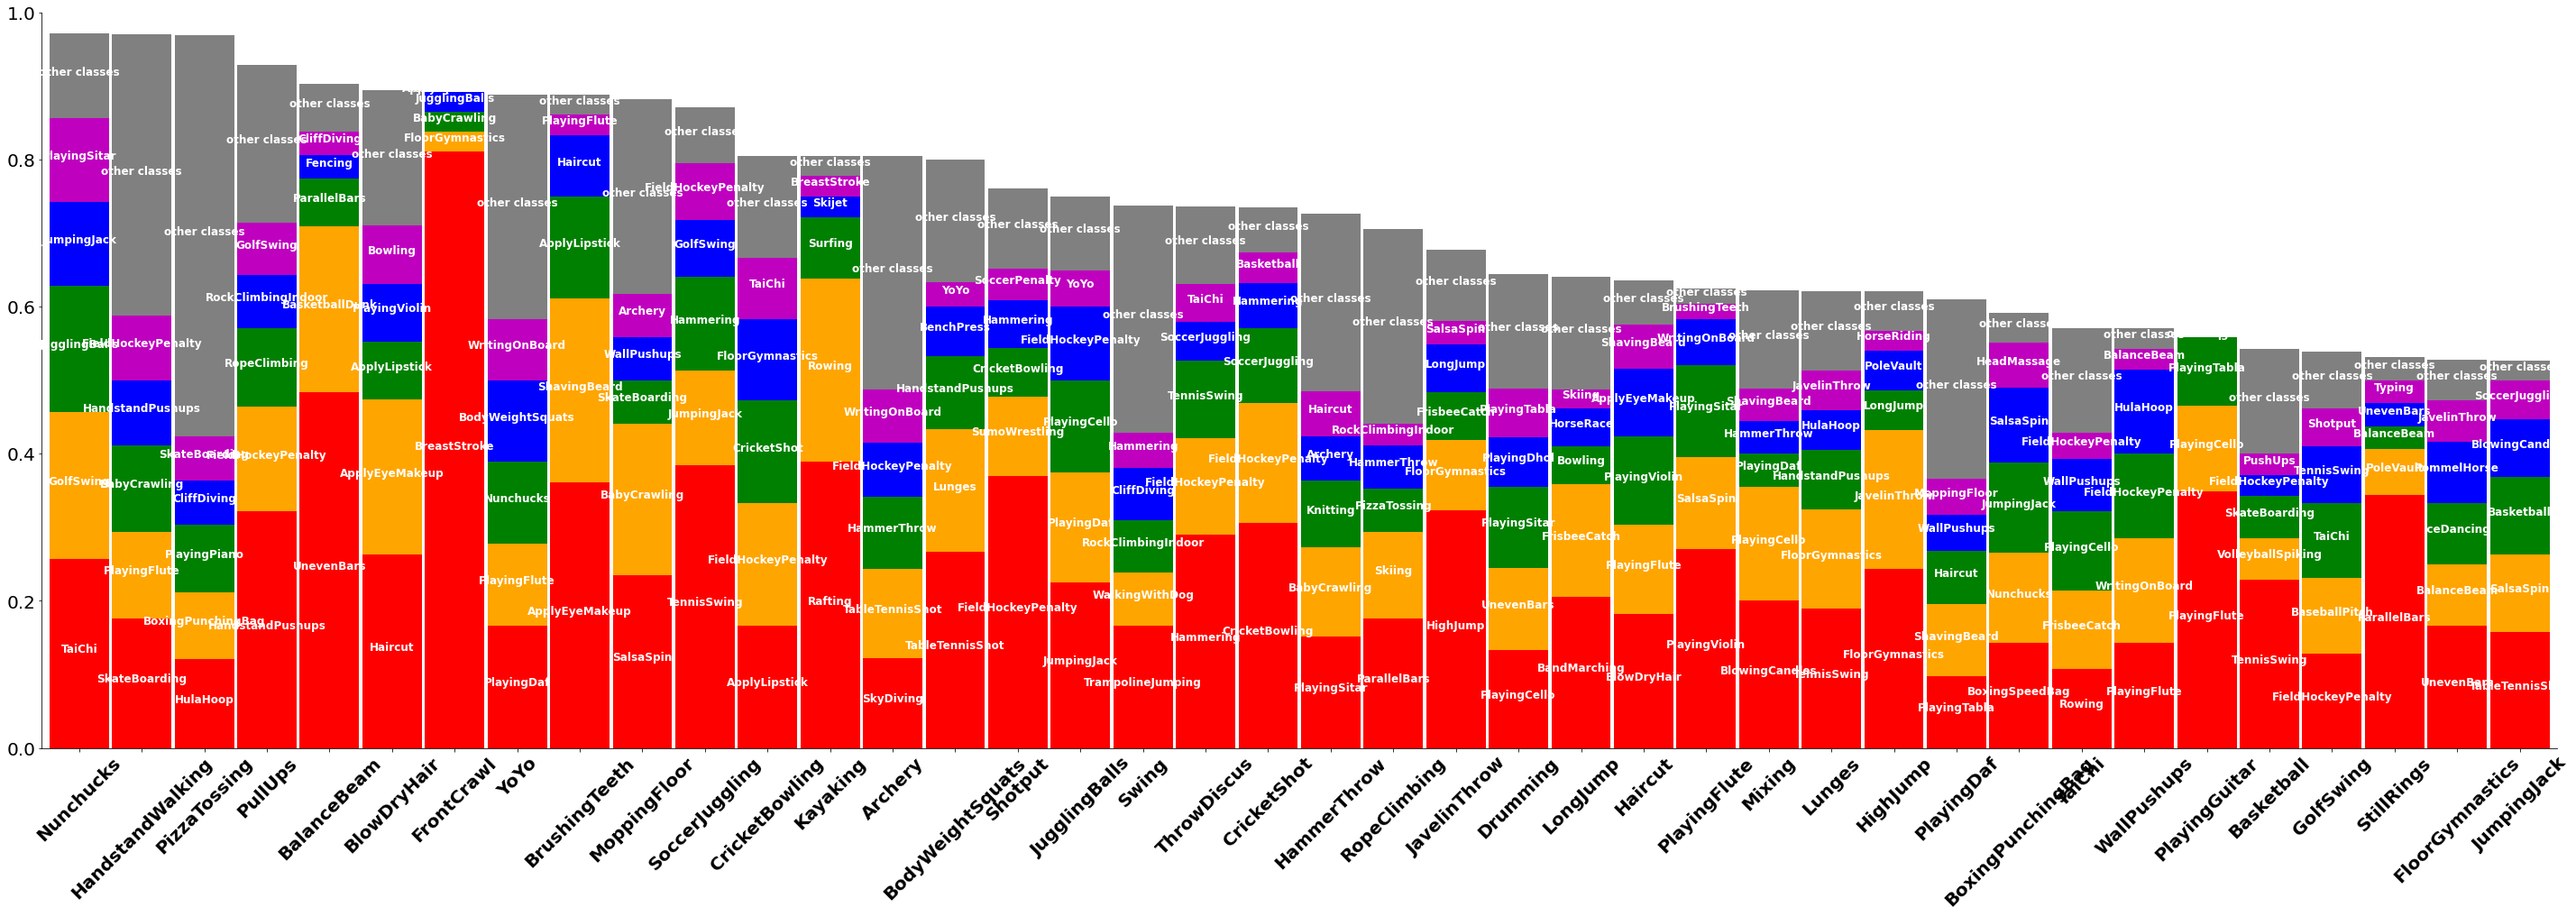

In [22]:
barWidth = 0.95

fig = plt.figure(figsize=[50,15])

colors = ['r', 'orange', 'g', 'b', 'm', 'c', 'purple', 'black']
prev_heights = np.zeros([len(worst_classes)]) 
prev_ours_heights = np.zeros([len(worst_classes)])
for i,(color,ref_cur_errs, ours_cur_errs) in enumerate(zip(colors,ref_err_rates_top_k_T_acc, err_rates_top_k_T_acc)):
    cur_rect = plt.bar(worst_range, ref_cur_errs, width=barWidth, zorder=-i, color=color)
    xs,ys,widths,heights = get_coords(cur_rect)
    ref_ys = (heights-prev_heights)/2 + prev_heights
    autolabel_bar(ref_filt_missclassified[:,i], xs, widths, ref_ys, plt, align='center')
    prev_heights = heights
    
# plt.title('Top-{} error rate per class of the baseline'.format(top_k_to_show), fontdict={'fontsize':25})
rects_ref = plt.bar(worst_range, ref_worst_k_class_err, width=barWidth, zorder=-10, color='grey')
xs,ys,widths,heights = get_coords(rects_ref)
ref_ys = (heights-prev_heights)/2 + prev_heights
autolabel_bar(['other classes']*len(worst_range), xs, widths, ref_ys, plt, align='center')

plt.xticks(worst_range,worst_classes,fontsize=20,rotation=45,weight='bold')
plt.yticks(fontsize=20)

plt.xlim([-0.6,len(worst_range)-0.4])
plt.ylim([0,1.0])

plt.show()
fig.savefig(ref_output_bar_chart_path,  bbox_inches='tight') 

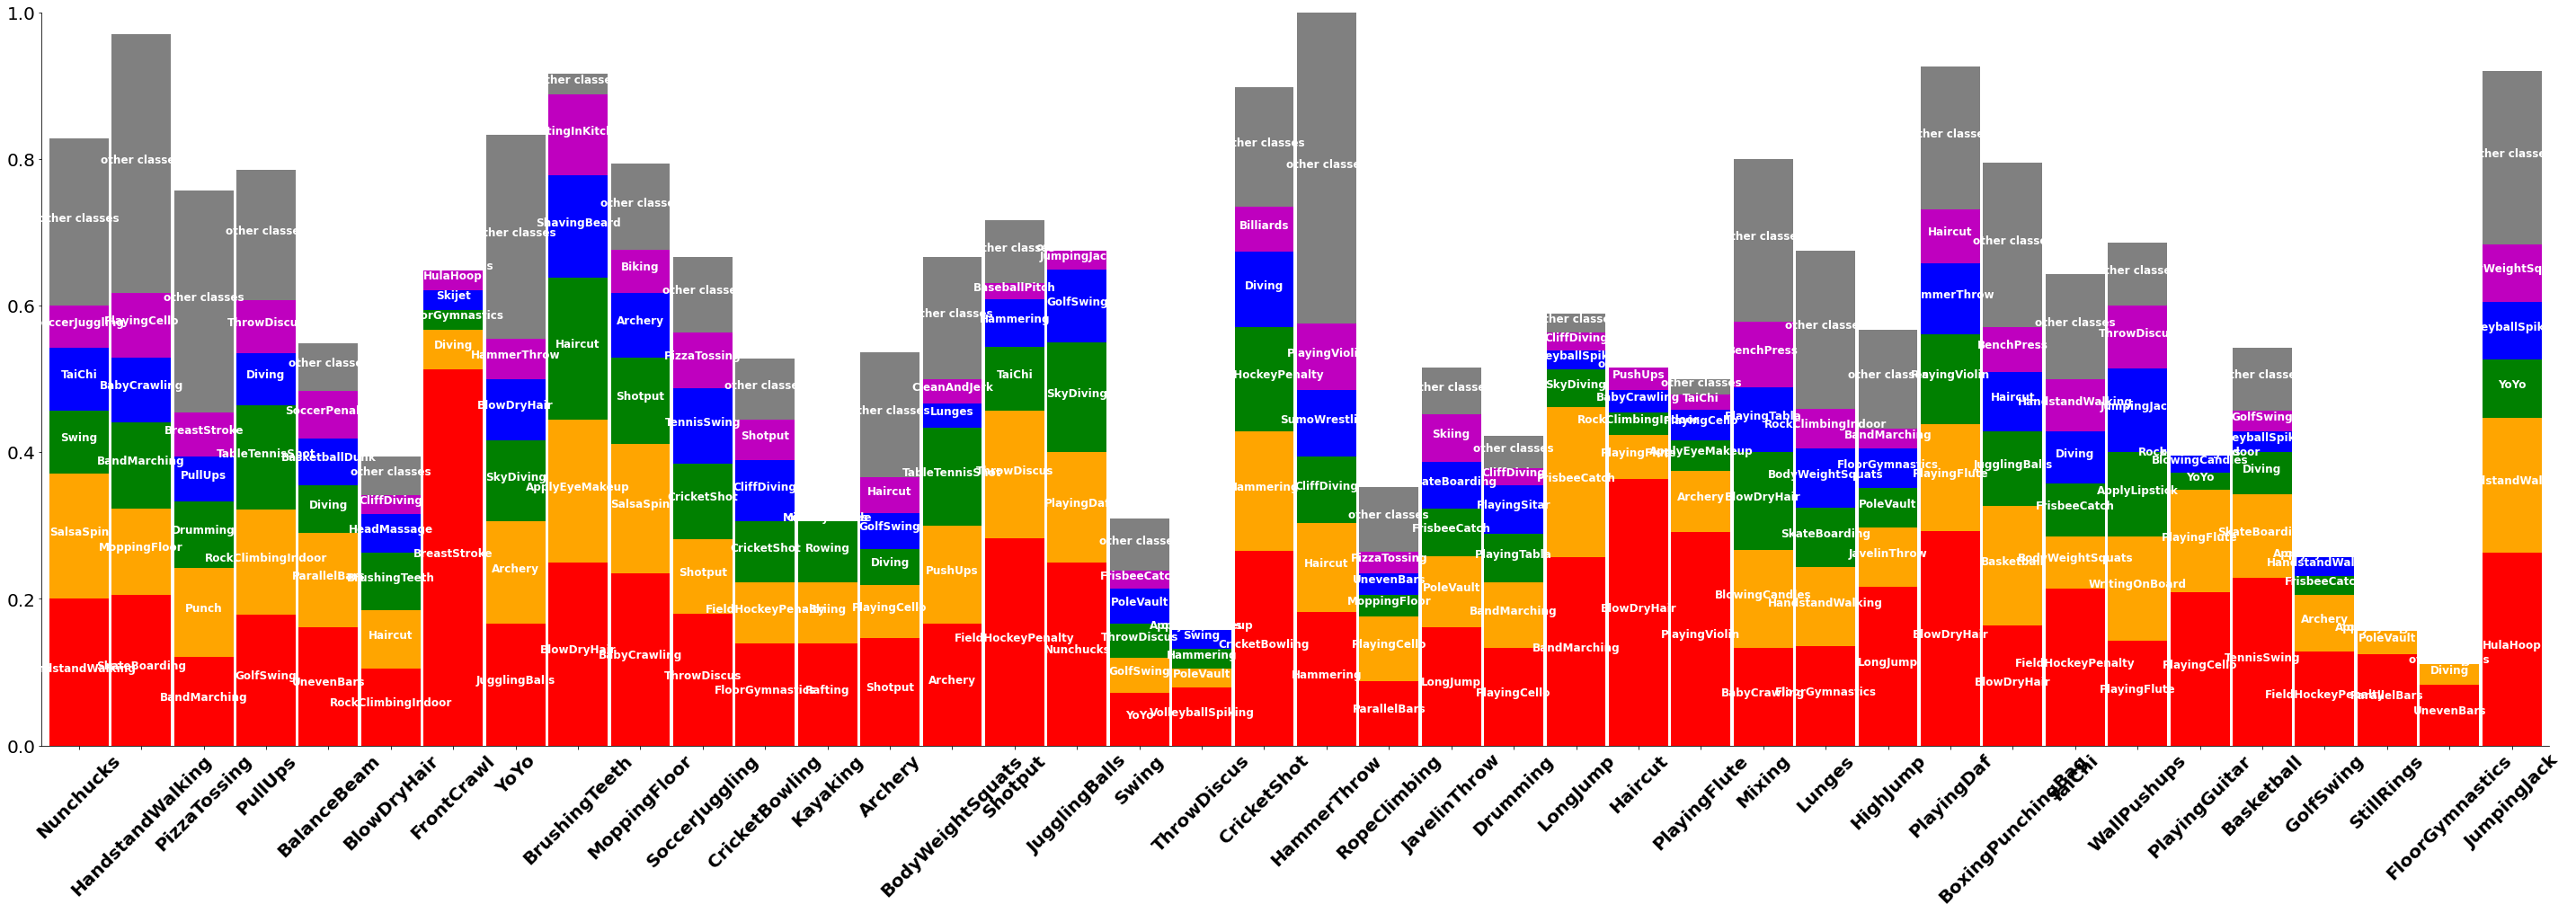

In [23]:
fig = plt.figure(figsize=[50,15])

colors = ['r', 'orange', 'g', 'b', 'm', 'c', 'purple', 'black']
prev_heights = np.zeros([len(worst_classes)]) 
prev_ours_heights = np.zeros([len(worst_classes)])
for i,(color,ref_cur_errs, ours_cur_errs) in enumerate(zip(colors,ref_err_rates_top_k_T_acc, err_rates_top_k_T_acc)):
    ours_cur_rect = plt.bar(worst_range, ours_cur_errs, width=barWidth, zorder=-i, color=color)
    ours_xs,ours_ys,ours_widths,ours_heights = get_coords(ours_cur_rect)
    ref_ys = (ours_heights-prev_ours_heights)/2 + prev_ours_heights
    autolabel_bar(comp_filt_missclassified[:,i], ours_xs, ours_widths, ref_ys, plt, align='center')
    prev_ours_heights = ours_heights
    
# plt.title('Error rate per class of our method for the corresponding worst-20 baseline classes'.format(top_k_to_show), fontdict={'fontsize':25})
rects_comp = plt.bar(worst_range, comp_ref_worst_k_class_err, width=barWidth,  zorder=-10, color='grey')
xs,ys,widths,heights = get_coords(rects_comp)
ref_ys = (heights-prev_ours_heights)/2 + prev_ours_heights
autolabel_bar(['other classes']*len(worst_range), xs, widths, ref_ys, plt, align='center')

plt.xticks(worst_range,worst_classes,fontsize=20,rotation=45,weight='bold')
plt.yticks(fontsize=20)

plt.xlim([-0.6,len(worst_range)-0.4])
plt.ylim([0,1.0])

plt.show()
fig.savefig(comp_output_bar_chart_path,  bbox_inches='tight') 